In [20]:
import numpy as np
from skimage.morphology import skeletonize, medial_axis, watershed, disk
from skimage import data
from scipy import ndimage as ndi
from scipy.spatial import distance
import matplotlib.pyplot as plt
from skimage.util import invert
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.feature import peak_local_max, canny
from scipy import ndimage
from skimage.filters import sobel
from skimage.measure import label, regionprops
from skimage.filters import rank

%matplotlib inline
import numpy as np
from skimage import io
from skimage.feature import canny
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage import segmentation
np.set_printoptions(threshold=np.nan)
import math
from skimage import morphology
from skimage.measure import label, regionprops
from skimage.feature import corner_harris, corner_subpix, corner_peaks

Preprocessed Image


/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


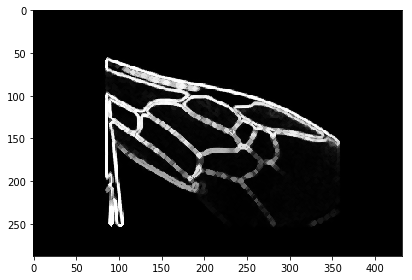

In [27]:
img = imread("enhanced_image/1 Lasioglossum leucozonium f left 3.2x.jpg")[:,:,0]
denoised = rank.median(img, disk(2))
markers = rank.gradient(denoised, disk(5)) < 10
markers = ndi.label(markers)[0]
gradient = rank.gradient(denoised, disk(2))
labels = watershed(gradient, markers)
cleared = segmentation.clear_border(labels)
imshow(img)
print("Preprocessed Image")

imshow(gradient)

/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


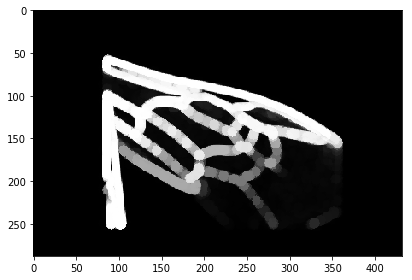

In [22]:
# # denoised = rank.median(img, disk(2))
# gradient = rank.gradient(denoised, disk(5))
# imshow(gradient)

[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


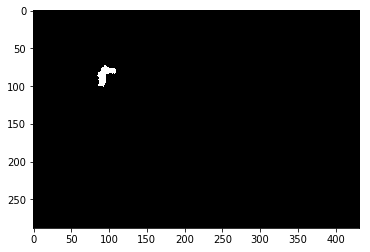

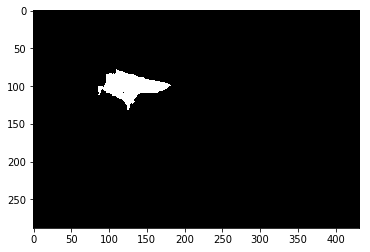

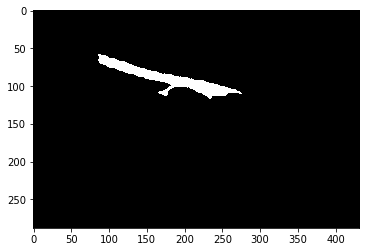

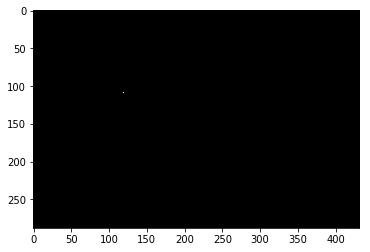

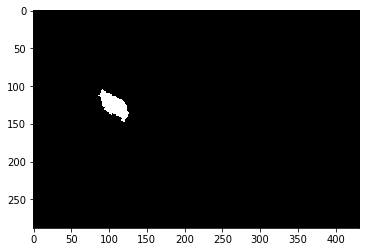

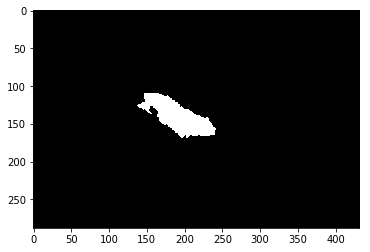

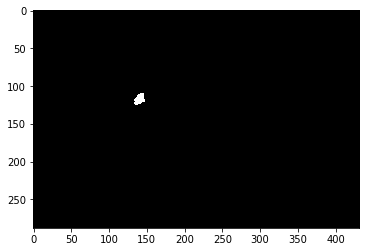

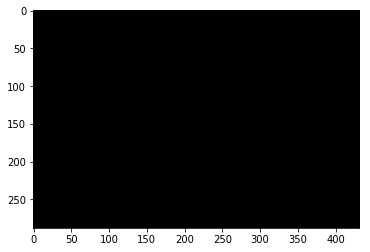

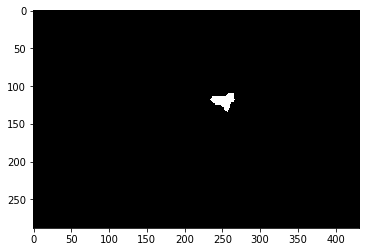

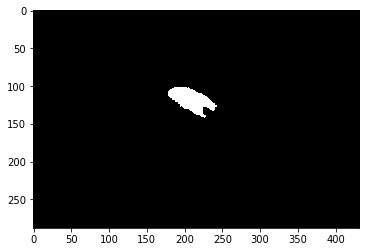

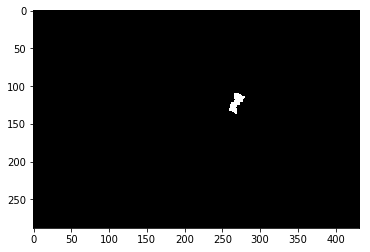

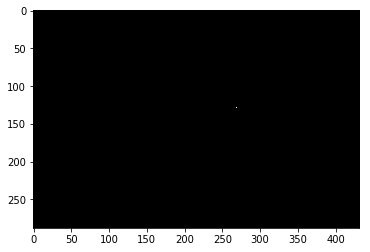

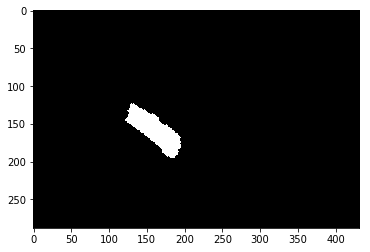

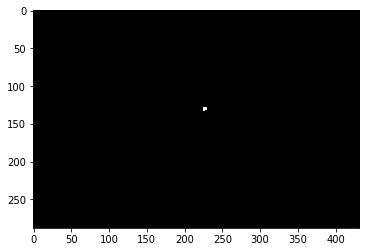

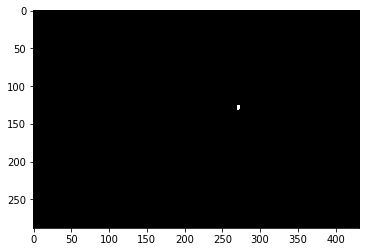

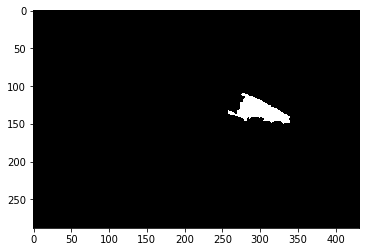

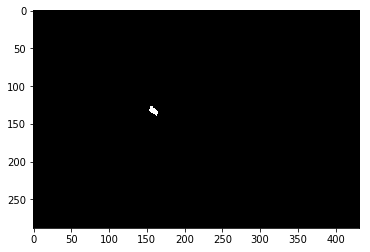

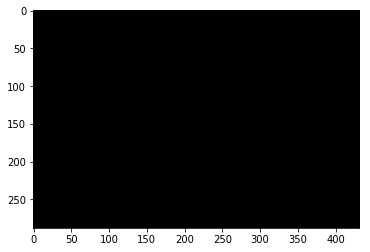

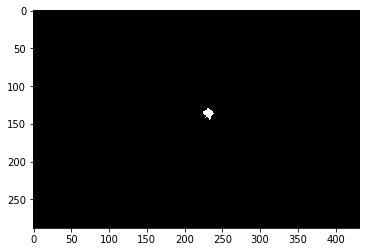

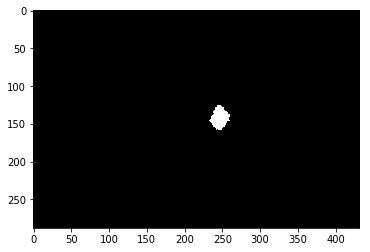

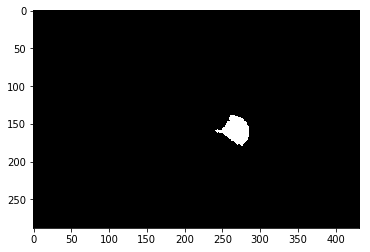

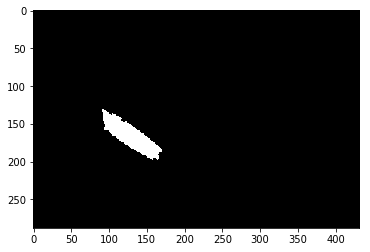

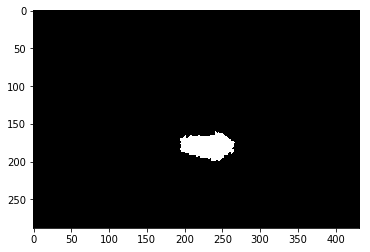

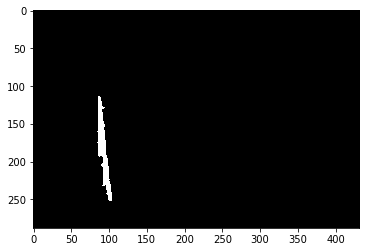

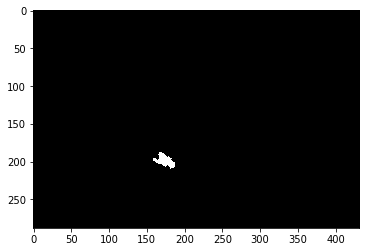

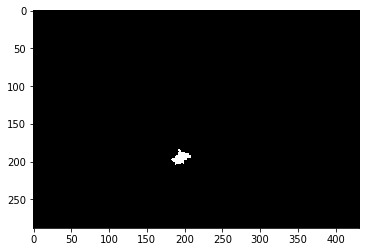

In [11]:
area = np.unique(cleared)
# for 5
print(area)
for i in area:
    if i != 0:
        copy_binary = np.zeros(cleared.shape)
        # image = np.zeros((, 600))

        copy_binary[cleared == i] = 1
        copy_binary[cleared != i] = 0
        # print(copy_binary)
        plt.figure()
        plt.imshow(copy_binary, cmap=plt.cm.gray)
        plt.show()

        image = copy_binary
        label_img = label(image)
        regions = regionprops(label_img)


Number of Regions:  26
Filtered Regions:  10


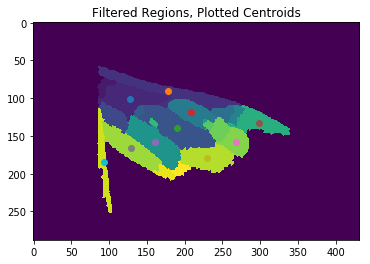

In [205]:
labeled_wing = cleared
regions = regionprops(labeled_wing)
print("Number of Regions: ", len(regions))
implot = plt.imshow(cleared)

#Filters regions based on area
filtered_regions = []
filtered_regions_area = []
for props in regions:
    area = props.area
#     print([500, 600] in props.coords)
    if area>1000 and area<400000:
        filtered_regions.append(props)
        filtered_regions_area.append(area)
print("Filtered Regions: ", len(filtered_regions))

#Plots centroids of regions
for region in filtered_regions:
    y0, x0 = region.centroid
    plt.scatter([x0], [y0])
plt.title("Filtered Regions, Plotted Centroids")
plt.show()

Center of Regions: 


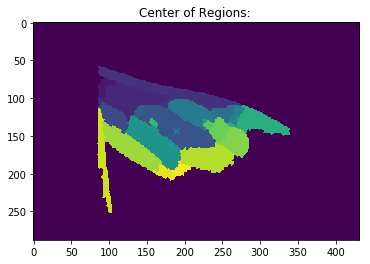

In [206]:
#Finds the centroid of all the region centers
# sum_x, sum_y = 0, 0
centroids = []
centroids_x = []
centroids_y = []
for region in filtered_regions:
    y0, x0 = region.centroid
    region_centroid = (x0, y0)
    centroids.append(region_centroid)
    centroids_x.append(x0)
    centroids_y.append(y0)
#     sum_x += x0
#     sum_y += y0
# avg_x = sum_x/len(filtered_regions)
# avg_y = sum_y/len(filtered_regions)
avg_x = np.mean(centroids_x)
avg_y = np.mean(centroids_y)

print("Center of Regions: ")
implot = plt.imshow(labeled_wing)
plt.scatter([avg_x], [avg_y], marker="x")
plt.title("Center of Regions: ")
plt.show()

In [207]:
#Calculates the distance between each centroid to the center
# implot = plt.imshow(labeled_wing)
distances_from_center = []
for centroid in centroids:
    distances_from_center.append(distance.euclidean(centroid, (avg_x, avg_y)))
# min_dist_centroid = centroids[distances_from_center.index(min(distances_from_center))]
# plt.scatter([min_dist_centroid[0]], [min_dist_centroid[1]])

#Normalizes distances from center using sd and mean
distance_sd = np.std(distances_from_center)
distance_mean = np.mean(distances_from_center)
# print("Distance Average", distance_mean, "Distance Standard Dev", distance_sd)
dist_from_cent_norm = [dist_from_center/distance_mean for dist_from_center in distances_from_center]
print("Distance, Scaled: \n", dist_from_cent_norm)

#Normalizes areas using sd and mean
area_sd = np.std(filtered_regions_area)
area_mean = np.mean(filtered_regions_area)
area_norm = [area/area_mean for area in filtered_regions_area ]
print("Area, Scaled: \n", area_norm)

Distance, Scaled: 
 [1.2080318996645132, 0.8752214101092546, 0.05762511326168648, 0.520264594696888, 0.5266016920604524, 1.8120307451785531, 1.3283859958769786, 1.0521305017384384, 0.9105296421972809, 1.7091784052159547]
Area, Scaled: 
 [1.1617444691436434, 1.3575738329628453, 1.5327617232984014, 0.7235101090293214, 1.2210225468402667, 0.8066052715147666, 0.5398539218799618, 1.0675346670900814, 1.0130200063512225, 0.5763734518894887]


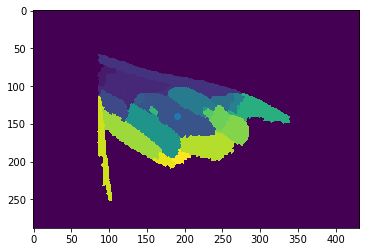

In [208]:
#Weights each region centroid based on distance to the center, and size
implot = plt.imshow(labeled_wing)
distance_weight = 1
size_weight = 1

weighted_values = []
for i in range(len(filtered_regions)):
    weighted_values.append(size_weight*area_norm[i] - distance_weight*dist_from_cent_norm[i])

max_index = weighted_values.index(max(weighted_values))
center_cell = filtered_regions[max_index]
# plt.scatter([centroids[max_index][0]], [centroids[max_index][1]])
center_cell_x, center_cell_y = center_cell.centroid[1], center_cell.centroid[0]
plt.scatter([center_cell_x], [center_cell_y])

/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


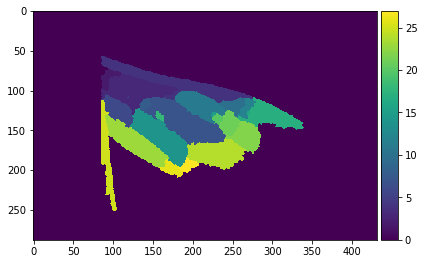

In [209]:
imshow(labeled_wing)

/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


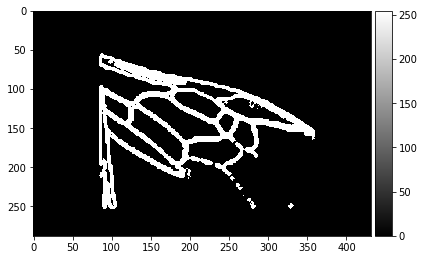

In [30]:
copy_image = np.zeros(np.shape(gradient))
copy_image[gradient > 30] = 255
# print(copy_image)
imshow(copy_image, cmap = plt.cm.gray)

/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


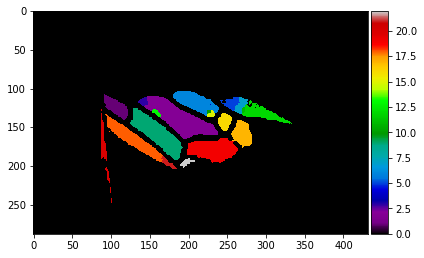

In [159]:
height, width = np.shape(labeled_wing)
vein_coord = []
for i in range(height):
    for j in range(width):
        if copy_image[i][j] != 0:
            vein_coord += [(i,j)]
            labeled_wing[i][j] = 0
            
imshow(labeled_wing, cmap = plt.cm.nipy_spectral)

Number of Regions:  22
Filtered Regions:  5


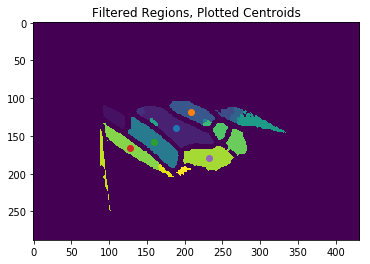

In [138]:
regions = regionprops(labeled_wing)
print("Number of Regions: ", len(regions))
plt.imshow(labeled_wing)

#Filters regions based on area
filtered_regions = []
filtered_regions_area = []
filter_info = {}
for idx, props in enumerate(regions):
    area = props.area
    if area > 1000 and area < 400000:
#         filter_info[idx] = [area, props.coords]
        filtered_regions.append(props)
        filtered_regions_area.append(area)
#     plt.figure()    
#     imshow(props.filled_image)
#     print(props.coords.shape)
#     print("===================")
#     area_coord = zip(props.coords)
#     print(area_coord[0])
        for i, j in props.coords:
            labeled_wing[i][j] = idx+1
        
print("Filtered Regions: ", len(filtered_regions))

# print(filtered_regions)
#Plots centroids of regions
for region in filtered_regions:
#     y0, x0 = region.centroid
#     plt.scatter([x0], [y0])
    
plt.title("Filtered Regions, Plotted Centroids")
plt.show()


/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/Users/Esther/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


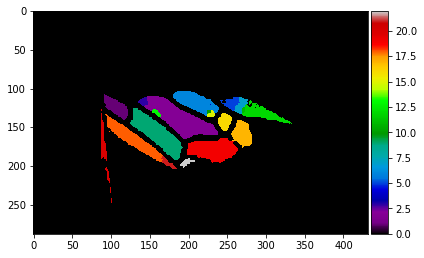

In [62]:
plt.figure()
imshow(labeled_wing, cmap = plt.cm.nipy_spectral)

Number of Regions:  1
Filtered Regions:  1


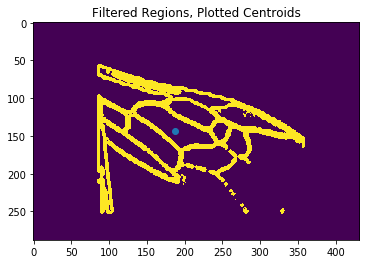

In [69]:
regions = regionprops(copy_image.astype(int))
print("Number of Regions: ", len(regions))
plt.imshow(copy_image)

#Filters regions based on area
filtered_regions = []
filtered_regions_area = []
for idx, props in enumerate(regions):
    area = props.area
    if area > 1000 and area < 400000:
        filtered_regions.append(props)
        filtered_regions_area.append(area)
#     plt.figure()    
#     imshow(props.filled_image)
#     print(props.coords.shape)
#     print("===================")
#     area_coord = zip(props.coords)
#     print(area_coord[0])
#         for i, j in props.coords:
#             print(idx, i, j)
#             labeled_wing[i][j] = idx+1
        
print("Filtered Regions: ", len(filtered_regions))

#Plots centroids of regions
for region in filtered_regions:
    y0, x0 = region.centroid
    plt.scatter([x0], [y0])
plt.title("Filtered Regions, Plotted Centroids")
plt.show()


Number of Regions:  1
11777
Filtered Regions:  1


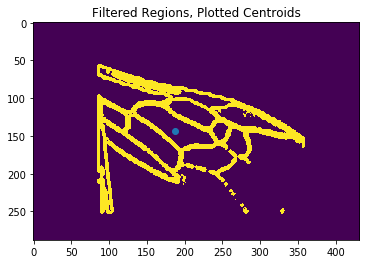

In [74]:
regions = regionprops(copy_image.astype(int))
print("Number of Regions: ", len(regions))
implot = plt.imshow(copy_image)

#Filters regions based on area
filtered_regions = []
filtered_regions_area = []
for props in regions:
    area = props.area
    print(area)
#     print([500, 600] in props.coords)
#     if area>1000 and area<400000:
    filtered_regions.append(props)
    filtered_regions_area.append(area)
print("Filtered Regions: ", len(filtered_regions))

#Plots centroids of regions
for region in filtered_regions:
    y0, x0 = region.centroid
    plt.scatter([x0], [y0])
plt.title("Filtered Regions, Plotted Centroids")
plt.show()

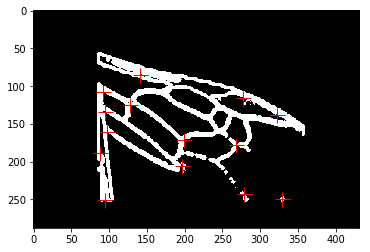

In [91]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks
image = copy_image # threashold
coords = corner_peaks(corner_harris(image), min_distance=23)
coords_subpix = corner_subpix(image, coords, window_size=10)

plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
# plt.set_title("Junction")

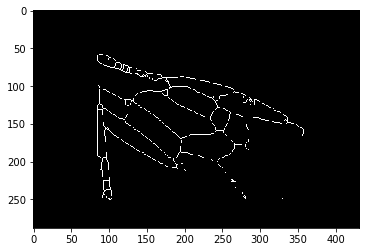

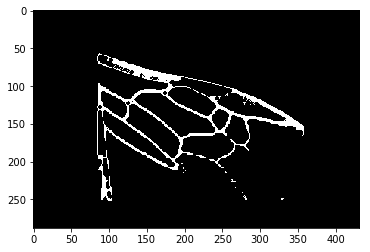

In [128]:
from skimage.morphology import skeletonize, thin

skeletonize_img = morphology.skeletonize(copy_image > 30)
plt.figure()
plt.imshow(skeletonize_img, cmap='gray')
# plt.set_title("skeletonize")

plt.figure()
thin_partial = thin(copy_image, max_iter=2)
plt.imshow(thin_partial, cmap='gray')

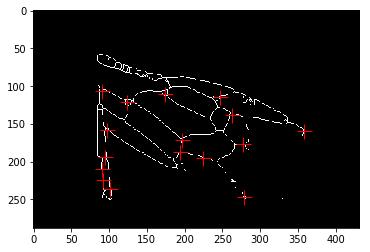

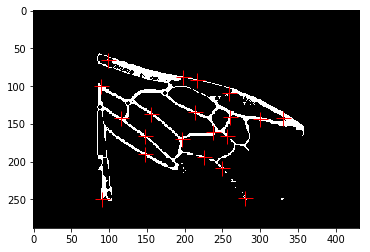

In [232]:
image = skeletonize_img # threashold
coords = corner_peaks(corner_harris(image), min_distance=8)
coords_subpix = corner_subpix(image, coords, window_size=10)

plt.figure()
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)

image = thin_partial # threashold
coords = corner_peaks(corner_harris(image), min_distance=12)
coords_subpix = corner_subpix(image, coords, window_size=10)

plt.figure()
plt.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)

# print(coords_subpix)

In [211]:
vein_coord[-7500:-7300]

[(125, 187),
 (125, 188),
 (125, 189),
 (125, 190),
 (125, 191),
 (125, 192),
 (125, 193),
 (125, 194),
 (125, 195),
 (125, 196),
 (125, 197),
 (125, 198),
 (125, 199),
 (125, 200),
 (125, 240),
 (125, 241),
 (125, 242),
 (125, 243),
 (125, 244),
 (125, 245),
 (125, 246),
 (125, 247),
 (125, 248),
 (125, 249),
 (125, 250),
 (125, 286),
 (125, 291),
 (125, 298),
 (125, 299),
 (125, 300),
 (125, 301),
 (125, 302),
 (125, 303),
 (125, 304),
 (125, 305),
 (125, 306),
 (125, 307),
 (125, 308),
 (125, 309),
 (125, 310),
 (125, 311),
 (125, 312),
 (125, 313),
 (125, 314),
 (125, 315),
 (125, 316),
 (126, 84),
 (126, 85),
 (126, 86),
 (126, 87),
 (126, 88),
 (126, 89),
 (126, 90),
 (126, 91),
 (126, 92),
 (126, 93),
 (126, 94),
 (126, 95),
 (126, 121),
 (126, 122),
 (126, 123),
 (126, 124),
 (126, 125),
 (126, 126),
 (126, 127),
 (126, 128),
 (126, 135),
 (126, 136),
 (126, 137),
 (126, 138),
 (126, 139),
 (126, 140),
 (126, 141),
 (126, 142),
 (126, 143),
 (126, 144),
 (126, 145),
 (126, 188)

In [212]:
center_cell_position

[(126, 129),
 (126, 130),
 (126, 131),
 (126, 132),
 (126, 133),
 (126, 134),
 (127, 129),
 (127, 130),
 (127, 131),
 (127, 132),
 (127, 133),
 (127, 134),
 (127, 135),
 (128, 129),
 (128, 130),
 (128, 131),
 (128, 132),
 (128, 133),
 (128, 134),
 (128, 135),
 (128, 136),
 (129, 129),
 (129, 130),
 (129, 131),
 (129, 132),
 (129, 133),
 (129, 134),
 (129, 135),
 (129, 136),
 (129, 137),
 (129, 138),
 (130, 129),
 (130, 130),
 (130, 131),
 (130, 132),
 (130, 133),
 (130, 134),
 (130, 135),
 (130, 136),
 (130, 137),
 (130, 138),
 (130, 139),
 (131, 129),
 (131, 130),
 (131, 131),
 (131, 132),
 (131, 133),
 (131, 134),
 (131, 135),
 (131, 136),
 (131, 137),
 (131, 138),
 (131, 139),
 (131, 140),
 (131, 141),
 (132, 129),
 (132, 130),
 (132, 131),
 (132, 132),
 (132, 133),
 (132, 134),
 (132, 135),
 (132, 136),
 (132, 137),
 (132, 138),
 (132, 139),
 (132, 140),
 (132, 141),
 (132, 142),
 (133, 129),
 (133, 130),
 (133, 131),
 (133, 132),
 (133, 133),
 (133, 134),
 (133, 135),
 (133, 136),

In [225]:
# center_cell.area
center_cell_position = []
index = 0
for i, j in center_cell.coords:
    center_cell_position += [(i, j)]
#     labeled_wing[i][j] = idx+1
    index += 1

print(len(center_cell_position))
insetsection = [] # set(center_cell_position) & set(vein_coord)

for i, j in center_cell_position:
    for m, n in vein_coord:
        if abs(i-m) <= 4 and abs(j-n) <= 4:
            insetsection += [(j, i)]
print(len(insetsection))

2896
56219


In [226]:
center_border_i = []
center_border_j = []
for i, j in insetsection:
    center_border_i += [i]
    center_border_j += [j]

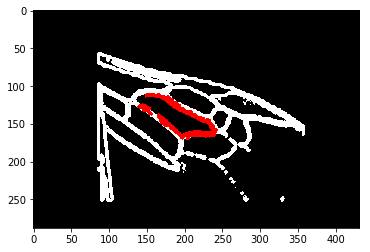

In [224]:
plt.figure()
plt.imshow(copy_image, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(center_border_i, center_border_j, '+r', markersize=1)

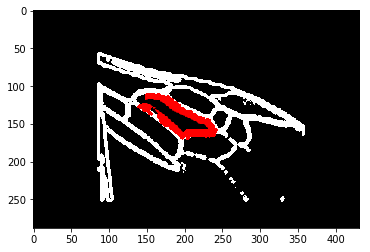

In [227]:
plt.figure()
plt.imshow(copy_image, interpolation='nearest', cmap=plt.cm.gray)
plt.plot(center_border_i, center_border_j, '+r', markersize=1)